In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

## Allen data preprocessing
Get AllenData sessions

In [2]:
basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

Select a session randomly

In [3]:
session_id = 799864342
session = cache.get_session_data(session_id)

print(session.structure_acronyms)
print(session.stimulus_names)

['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
['spontaneous', 'gabors', 'flashes', 'drifting_gratings', 'natural_movie_three', 'natural_movie_one', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast']


Select 'drifting_gratings' stimuli with contrast 0.8 and temporal_frequency 15.0, but 8 different orientations. 
Each stimuli was presented 15 times for 2 seconds

In [4]:
stim_table = session.get_stimulus_table('drifting_gratings')
print(stim_table['temporal_frequency'].value_counts())

stim_orientation_table = stim_table[stim_table['temporal_frequency'] == 15.0 ]
print(stim_orientation_table['orientation'].value_counts())
print(stim_orientation_table['stimulus_condition_id'].value_counts())
stim_orientation_table.head()

15.0    120
8.0     120
4.0     120
2.0     120
1.0     120
null     30
Name: temporal_frequency, dtype: int64
270.0    15
45.0     15
315.0    15
90.0     15
135.0    15
180.0    15
225.0    15
0.0      15
Name: orientation, dtype: int64
254    15
252    15
248    15
247    15
277    15
272    15
267    15
256    15
Name: stimulus_condition_id, dtype: int64


,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3800,0.8,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1596.315739,2,drifting_gratings,1598.317439,15,2.00170,248
3805,0.8,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1611.328291,2,drifting_gratings,1613.329971,15,2.00168,252
3807,0.8,90,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1617.333321,2,drifting_gratings,1619.334971,15,2.00165,254
3809,0.8,315,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1623.338331,2,drifting_gratings,1625.340001,15,2.00167,256


Select units from VISam area as X_a and VISmma area as X_b

In [9]:
VISam_units = session.units[session.units["ecephys_structure_acronym"] == 'VISam']
VISmma_units = session.units[session.units["ecephys_structure_acronym"] == 'VISmma']

Count spikes in 100ms bins after stimuli onset and spaning a total of 2 seconds

In [6]:
print(stim_orientation_table.duration)
time_step = 0.1
time_bins = np.arange(0, 2 + time_step, time_step)
time_bins

stimulus_presentation_id
3799     2.00168
3800     2.00170
3805     2.00168
3807     2.00165
3809     2.00167
          ...   
49396    2.00167
49409    2.00167
49416    2.00166
49421    2.00169
49426    2.00167
Name: duration, Length: 120, dtype: float64
[3.73805642e-06 7.69174221e-06 1.99947524e-05 ... 9.51107329e+08
 9.51107337e+08 9.51108474e+08]


stimulus_presentation_id  unit_id    time_since_stimulus_presentation_onset
49426                     951108474  1.823973                                  1
31018                     951108474  1.072702                                  1
                                     1.014002                                  1
                                     0.860202                                  1
                                     0.848169                                  1
                                                                              ..
49230                     951099069  1.825340                                  1
                                     1.802540                                  1
                                     1.790540                                  1
                                     1.784173                                  1
3799                      951087020  0.007310                                  1
Length: 217260, dtype: int64

Spike_counts in VISam

In [10]:
VISam_spike_counts = session.presentationwise_spike_counts(
    stimulus_presentation_ids=stim_orientation_table.index.values,  
    bin_edges=time_bins,
    unit_ids=VISam_units.index.values
)
print(VISam_spike_counts.shape)
print(VISam_spike_counts.coords)
VISam_spike_counts['stimulus_presentation_id'].values.shape

(120, 20, 29)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3799 ... 49426
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.05 ... 1.95
  * unit_id                          (unit_id) int64 951087804 ... 951088476


(120,)

(120, 20, 29)
(2400, 29)


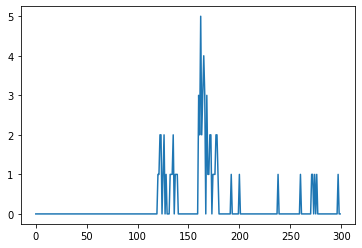

In [15]:
# convert spike_counts structure from stimulus_presentation_id*time_bins* unit_id 
# to stimulus_bins_counts * units, (120, 20, 109) -> (2400, 109)

counts_matrix = VISam_spike_counts.values
print(counts_matrix.shape)
VISam_counts = counts_matrix.reshape(counts_matrix.shape[0]*counts_matrix.shape[1], counts_matrix.shape[2])
print(VISam_counts.shape)

plt.figure()
plt.plot(VISam_counts[:300, 0])

Spike_counts in VISmma

In [11]:
VISmma_spike_counts = session.presentationwise_spike_counts(
    stimulus_presentation_ids=stim_orientation_table.index.values,  
    bin_edges=time_bins,
    unit_ids=VISmma_units.index.values
)
print(VISmma_spike_counts.shape)
print(VISmma_spike_counts.coords)
VISmma_spike_counts['stimulus_presentation_id'].values.shape

(120, 20, 44)
Coordinates:
  * stimulus_presentation_id         (stimulus_presentation_id) int64 3799 ... 49426
  * time_relative_to_stimulus_onset  (time_relative_to_stimulus_onset) float64 0.05 ... 1.95
  * unit_id                          (unit_id) int64 951091096 ... 951092146


(120,)

(120, 20, 44)
(2400, 44)


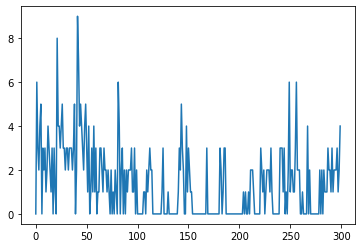

In [16]:
# convert spike_counts structure from stimulus_presentation_id*time_bins* unit_id 
# to stimulus_bins_counts * units, (120, 20, 109) -> (2400, 109)

counts_matrix = VISmma_spike_counts.values
print(counts_matrix.shape)
VISmma_counts = counts_matrix.reshape(counts_matrix.shape[0]*counts_matrix.shape[1], counts_matrix.shape[2])
print(VISmma_counts.shape)

plt.figure()
plt.plot(VISmma_counts[:300, 0])

## CCA between VISam (X_a) and VISmma (X_b)

In [17]:
X_a = VISam_counts
X_b = VISmma_counts

print(X_a.shape)
print(X_b.shape)

(2400, 29)
(2400, 44)


Standardize data to zero mean and unit variance

In [20]:
X_a = X_a - X_a.mean(axis=0)
X_a = X_a / X_a.std(axis=0)

X_b = X_b - X_b.mean(axis=0)
X_b = X_b / X_b.std(axis=0)

Compute covariance matrix for X_a and X_b

In [21]:
N = X_a.shape[0]     # samples number
normalizer = N - 1   # for estimate

Cov_aa = np.dot(X_a.T, X_a) / normalizer
Cov_bb = np.dot(X_b.T, X_b) / normalizer
Cov_ab = np.dot(X_a.T, X_b) / normalizer
Cov_ba = np.dot(X_b.T, X_a) / normalizer

Calculate weight for CCA model with eigval methods
refer to [Canonical Correlation Analysis in Detail](https://gregorygundersen.com/blog/2018/07/17/cca/)

$$\rho^2w_b = (\Sigma_{bb}^{-1}\Sigma_{ba}\Sigma_{aa}^{-1}\Sigma_{ab})w_b$$

this is the standard eigenvalue problem
$w_b$ is an eigenvector that satisfies this equation:

$$(\Sigma_{bb}^{-1}\Sigma_{ba}\Sigma_{aa}^{-1}\Sigma_{ab}-\rho^2I)w_b = 0$$

solving for $w_a$:

$$w_a = \frac{\Sigma_{aa}^{-1}\Sigma_{ab}w_b}{\rho}$$

In [146]:
p = X_a.shape[1]
q = X_b.shape[1]
r = min(p, q)

# if q < p:
#     M = np.dot(np.linalg.inv(Cov_bb), Cov_ba) @ \
#         np.dot(np.linalg.inv(Cov_aa), Cov_ab)
# else:
#     M = np.dot(np.linalg.inv(Cov_aa), Cov_ab) @ \
#         np.dot(np.linalg.inv(Cov_bb), Cov_ba)

# rank of M should be r = min(p, q)
M = np.dot(np.linalg.inv(Cov_bb), Cov_ba) @ \
    np.dot(np.linalg.inv(Cov_aa), Cov_ab)

eigvals, eigvecs = np.linalg.eig(M)
rhos = np.sqrt(eigvals)

# print(rhos)
# print(eigvals)
print(eigvals.shape)
print(eigvecs.shape)

(44,)
(44, 44)


In [125]:
# sort eigvecs in descending order
inds = (-rhos).argsort()[:r]  

# if p < q:
#     inds = inds[:p]

rhos = rhos[inds]
print(rhos)
eigvals = eigvals[inds]
eigvecs = eigvecs[:, inds]

# w_b is eigvecs, should be (q, r)
w_b = eigvecs
print(f'X_b: {X_b.shape}')
print(f'the weight of X_b: {w_b.shape}')

# calcute w_a from w_b
w_a = np.zeros((p, r))
for i, (rho, wb_i) in enumerate(zip(rhos, w_b.T)):
    wa_i = (np.dot(np.linalg.inv(Cov_aa), Cov_ab) @ \
        wb_i) / rho
    w_a[:, i] = wa_i
print(f'X_a: {X_a.shape}')
print(f'the weight of X_a: {w_a.shape}')

[0.7058069 +0.j 0.68786743+0.j 0.47318988+0.j 0.45819591+0.j
 0.41271742+0.j 0.37554621+0.j 0.3218447 +0.j 0.31325722+0.j
 0.27267834+0.j 0.26793165+0.j 0.2482555 +0.j 0.23968759+0.j
 0.21952742+0.j 0.20940324+0.j 0.19581103+0.j 0.18347668+0.j
 0.17732267+0.j 0.15969174+0.j 0.14959651+0.j 0.13133742+0.j
 0.1156771 +0.j 0.11060828+0.j 0.10502269+0.j 0.10116765+0.j
 0.09248444+0.j 0.08725858+0.j 0.07475627+0.j 0.06470771+0.j
 0.0574828 +0.j]
X_b: (2400, 44)
the weight of X_b: (44, 29)
X_a: (2400, 29)
the weight of X_a: (29, 29)


E:\download_files\anaconda_app\envs\env_py_362\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


Embeddings for X_a and X_b

? why corr_z component 1 is largest; however, pho 0 is largest

(2400, 29)
(2400, 29)
(2400, 29)
(2400, 29)


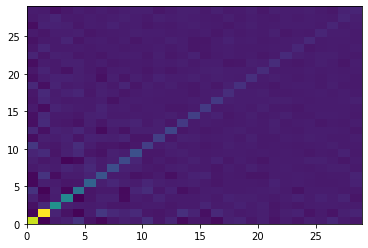

In [143]:
z_a = X_a @ w_a
z_b = X_b @ w_b

print(z_a.shape)
print(z_b.shape)

# normalize
z_a = z_a.T / np.linalg.norm(z_a.T, 2, axis=0)
z_a = z_a.T
z_b = z_b.T / np.linalg.norm(z_b.T, 2, axis=0)
z_b = z_b.T
print(z_a.shape)
print(z_b.shape)

corr_z_map = np.dot(z_a.T, z_b)
corr_z_map = corr_z_map.real

f, ax = plt.subplots()
ax.pcolormesh(corr_z_map)
plt.show()

In [144]:
corr_z_map = np.dot(z_a.T, z_b) / (np.sqrt(np.dot(z_a.T, z_a)) *\
    np.sqrt(np.dot(z_b.T, z_b)))
corr_z_map = corr_z_map.real

dia_ind = np.arange(0, r)
corr_z = corr_z_map[dia_ind, dia_ind]
corr_z

E:\download_files\anaconda_app\envs\env_py_362\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
E:\download_files\anaconda_app\envs\env_py_362\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([0.67301996, 0.68252009, 0.46817374, 0.45232543, 0.408564  ,
       0.34694998, 0.27397088, 0.26146288, 0.24431851, 0.24498827,
       0.21193853, 0.18459067, 0.21407983, 0.18220652, 0.17646089,
       0.18062369, 0.16610525, 0.12717383, 0.12586797, 0.12380653,
       0.10892194, 0.10282855, 0.08029283, 0.06444959, 0.0795354 ,
       0.06411186, 0.06511469, 0.06026281, 0.04782027])

plot embeddng dimsensions

C:\Users\jiang\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


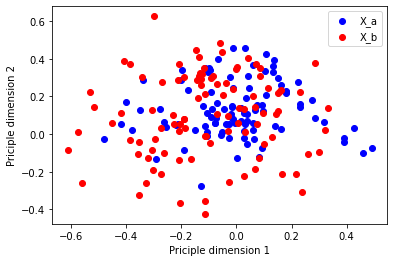

In [133]:
n_components = 2 # principle components
n_samples = 100

z_a_1 = z_a[:, :n_components]
z_b_1 = z_b[:, :n_components]

fig, ax = plt.subplots()
ax1 = ax.scatter(z_a_1[:n_samples, 0], z_a_1[:n_samples, 1], c='blue')
ax2 = ax.scatter(z_b_1[:n_samples, 0], z_b_1[:n_samples, 1], c='red')
ax.set_xlabel('Priciple dimension 1')
ax.set_ylabel('Priciple dimension 2')
ax.legend([ax1, ax2], ['X_a', 'X_b'])

# for i, txt in enumerate(range(len(z_a))):
#     ax.annotate(txt, (z_a[:, 0][i], z_a[:, 1][i]), color='blue')

# for i, txt in enumerate(range(len(z_b))):
#     ax.annotate(txt, (z_b[:, 0][i], z_b[:, 1][i]), color='red')

plt.show()

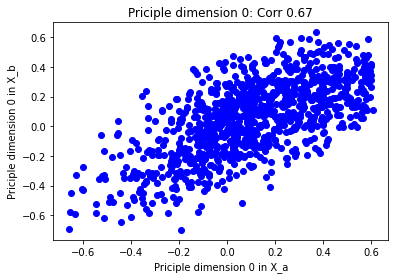

In [134]:
component = 0 # principle components
n_samples = 1000

z_a_2 = z_a[:, component]
z_b_2 = z_b[:, component]

fig, ax = plt.subplots()
ax1 = ax.scatter(z_a_2[:n_samples], z_b_2[:n_samples], c='blue')

ax.set_xlabel(f'Priciple dimension {component} in X_a')
ax.set_ylabel(f'Priciple dimension {component} in X_b')
ax.set_title(f'Priciple dimension {component}: Corr {corr_z[component]:.2f}')
plt.show()

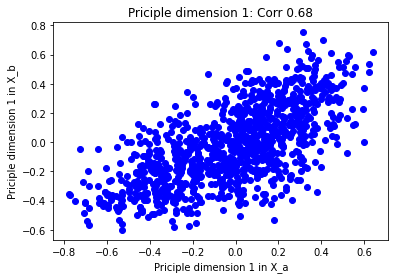

In [135]:
component = 1 # principle components
n_samples = 1000

z_a_2 = z_a[:, component]
z_b_2 = z_b[:, component]

fig, ax = plt.subplots()
ax1 = ax.scatter(z_a_2[:n_samples], z_b_2[:n_samples], c='blue')

ax.set_xlabel(f'Priciple dimension {component} in X_a')
ax.set_ylabel(f'Priciple dimension {component} in X_b')
ax.set_title(f'Priciple dimension {component}: Corr {corr_z[component]:.2f}')
plt.show()

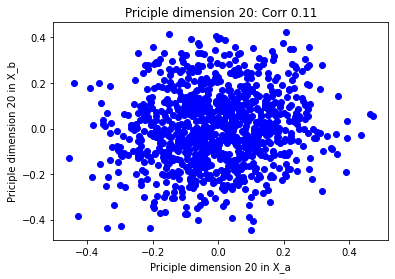

In [136]:
component = 20 # principle components
n_samples = 1000

z_a_2 = z_a[:, component]
z_b_2 = z_b[:, component]

fig, ax = plt.subplots()
ax1 = ax.scatter(z_a_2[:n_samples], z_b_2[:n_samples], c='blue')

ax.set_xlabel(f'Priciple dimension {component} in X_a')
ax.set_ylabel(f'Priciple dimension {component} in X_b')
ax.set_title(f'Priciple dimension {component}: Corr {corr_z[component]:.2f}')
plt.show()